In [4]:
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt


nginx = {
    "name": "Nginx",
    "ip": "nginx.antoniszczepanik.com",
}

h2o = {
    "name": "H2O",
    "ip": "h2o.antoniszczepanik.com",
}

caddy = {
    "name": "Caddy",
    "ip": "caddy.antoniszczepanik.com",
}

ls = {
    "name": "OpenLiteSpeed",
    "ip": "litespeed.antoniszczepanik.com",
}

iperf_port = "6969"

servers = (nginx, h2o, caddy, ls)

def get_throughput(res):
    tp = None
    try:
        fin_line = [l for l in res if l.startswith("finished in ")][0]
        tp = float(fin_line.split(" ")[-1][:-4])
    except:
        print("Could not get throughput!")
        print(res)
    return tp

def get_rps(res):
    rps = None
    try:
        fin_line = [l for l in res if l.startswith("finished in ")][0]
        rps = float(fin_line.split(" ")[3])
    except:
        print("Could not get RPS")
        print(rps)
    return rps

def get_success_pct(res):
    req_line = [l for l in res if l.startswith("requests:")][0]
    items = req_line.split(" ")
    return float(items[7])/float(items[1])

def get_title_from_subplot(sup_title):
    for s in servers:
        if s['name'].lower() in sup_title.lower():
            return s['name']
    return "ERROR: unknown server"

## Bandwidth and latency test

### Latency

In [11]:
for server in servers:
    print("")
    print(f"==================== PING {server['name']} ==========================")
    !ping -c 5 {server["ip"]}


==================== PING Nginx ==========================
PING nginx.antoniszczepanik.com (18.159.234.10) 56(84) bytes of data.
64 bytes from ec2-18-159-234-10.eu-central-1.compute.amazonaws.com (18.159.234.10): icmp_seq=1 ttl=63 time=0.243 ms
64 bytes from ec2-18-159-234-10.eu-central-1.compute.amazonaws.com (18.159.234.10): icmp_seq=2 ttl=63 time=0.250 ms
64 bytes from ec2-18-159-234-10.eu-central-1.compute.amazonaws.com (18.159.234.10): icmp_seq=3 ttl=63 time=0.231 ms
64 bytes from ec2-18-159-234-10.eu-central-1.compute.amazonaws.com (18.159.234.10): icmp_seq=4 ttl=63 time=0.285 ms
64 bytes from ec2-18-159-234-10.eu-central-1.compute.amazonaws.com (18.159.234.10): icmp_seq=5 ttl=63 time=0.230 ms

--- nginx.antoniszczepanik.com ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4064ms
rtt min/avg/max/mdev = 0.230/0.247/0.285/0.020 ms

==================== PING H2O ==========================
PING h2o.antoniszczepanik.com (3.72.136.224) 56(84) bytes of data.


### Bandwidth - TCP & UDP

In [3]:
# TODO: Make sure iperf is running on all servers.
!iperf -c {nginx["ip"]} -p {iperf_port}
!iperf -u -c {nginx["ip"]} -p {iperf_port} -b 0

Connecting to host nginx.antoniszczepanik.com, port 6969
[  5] local 172.31.8.21 port 58462 connected to 18.159.234.10 port 6969
[ ID] Interval           Transfer     Bitrate         Retr  Cwnd
[  5]   0.00-1.00   sec   304 MBytes  2.55 Gbits/sec  844    144 KBytes       
[  5]   1.00-2.00   sec   292 MBytes  2.45 Gbits/sec  937    727 KBytes       
[  5]   2.00-3.00   sec   320 MBytes  2.68 Gbits/sec  845    358 KBytes       
[  5]   3.00-4.00   sec   431 MBytes  3.62 Gbits/sec  208    380 KBytes       
[  5]   4.00-5.00   sec   494 MBytes  4.14 Gbits/sec  925    450 KBytes       
[  5]   5.00-6.00   sec   476 MBytes  4.00 Gbits/sec  820    766 KBytes       
[  5]   6.00-7.00   sec   492 MBytes  4.13 Gbits/sec  618    276 KBytes       
[  5]   7.00-8.00   sec   519 MBytes  4.35 Gbits/sec  999    510 KBytes       
[  5]   8.00-9.00   sec   500 MBytes  4.19 Gbits/sec  452    315 KBytes       
[  5]   9.00-10.00  sec   458 MBytes  3.84 Gbits/sec  414    461 KBytes       
- - - - - - - - 

# Bulk Throughput

In [12]:
data_tp = {
    "server": [],
    "throughput": [],
    "protocol": [],
}

for server in servers:
    for protocol in ("h2", "h3",):
        print(f"bulk throughput test {protocol} - {server['name']}")
        # Request the file first, just to warm up caches.
        _ = !h2load -n1 -c1 --npn-list={protocol} https://{server['ip']}/1g.txt
        for i in range(20):
            res = !h2load -n1 -c1 --npn-list={protocol} https://{server['ip']}/1g.txt
            data_tp['server'].append(server['name'])
            data_tp['throughput'].append(get_throughput(res))
            data_tp['protocol'].append("HTTP/2" if protocol == "h2" else "HTTP/3")
            print(f"{get_throughput(res)} MB/s (succ: {get_success_pct(res)})")

bulk throughput test h2 - Nginx
415.25 MB/s (succ: 1.0)
428.07 MB/s (succ: 1.0)
409.27 MB/s (succ: 1.0)
385.43 MB/s (succ: 1.0)
384.3 MB/s (succ: 1.0)
460.76 MB/s (succ: 1.0)
465.62 MB/s (succ: 1.0)
487.01 MB/s (succ: 1.0)
421.3 MB/s (succ: 1.0)
521.94 MB/s (succ: 1.0)
434.14 MB/s (succ: 1.0)
437.87 MB/s (succ: 1.0)
397.96 MB/s (succ: 1.0)
405.21 MB/s (succ: 1.0)
376.99 MB/s (succ: 1.0)
336.53 MB/s (succ: 1.0)
370.59 MB/s (succ: 1.0)
435.71 MB/s (succ: 1.0)
462.87 MB/s (succ: 1.0)
461.66 MB/s (succ: 1.0)
bulk throughput test h3 - Nginx
119.0 MB/s (succ: 1.0)
138.14 MB/s (succ: 1.0)
128.54 MB/s (succ: 1.0)
133.58 MB/s (succ: 1.0)
125.28 MB/s (succ: 1.0)
126.06 MB/s (succ: 1.0)
141.93 MB/s (succ: 1.0)
135.9 MB/s (succ: 1.0)
122.17 MB/s (succ: 1.0)
133.28 MB/s (succ: 1.0)
141.83 MB/s (succ: 1.0)
128.79 MB/s (succ: 1.0)
130.91 MB/s (succ: 1.0)
120.31 MB/s (succ: 1.0)
129.97 MB/s (succ: 1.0)
130.48 MB/s (succ: 1.0)
129.49 MB/s (succ: 1.0)
138.12 MB/s (succ: 1.0)
129.58 MB/s (succ: 1.0)
136.

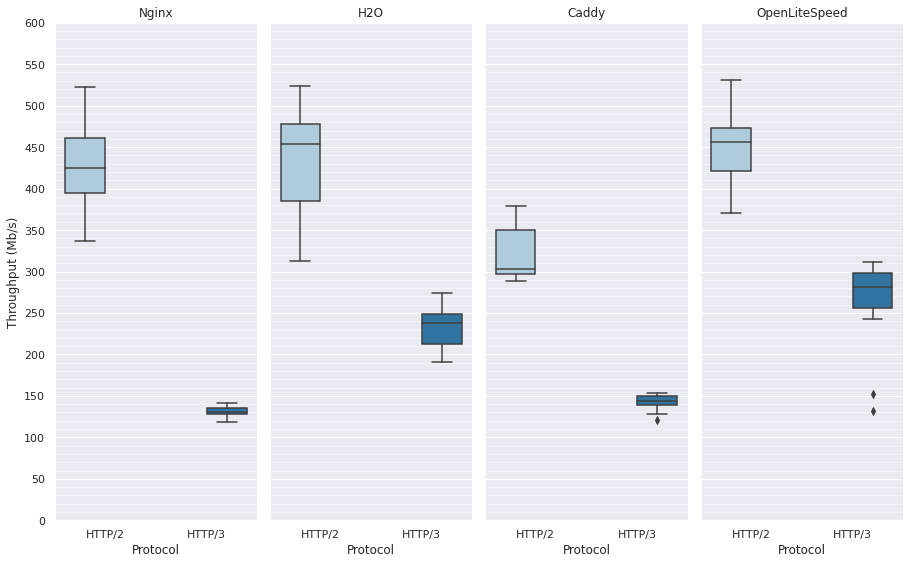

In [13]:
df_tp = pd.DataFrame(data_tp)
sns.set(rc={'figure.figsize':(30,10)})

# ax = sns.boxplot(x="server", y="throughput", hue="protocol", data=df_tp, palette="Set3")

g = sns.catplot(x="protocol", y="throughput",hue="protocol", col="server",data=df_tp, kind="box",height=8, aspect=.4, palette="Paired");
g.set_xlabels('Protocol')
g.set_ylabels('Throughput (Mb/s)')
for p in g.axes.flatten():
    p.set_title(get_title_from_subplot(str(p.title)))
    p.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    p.grid(visible=True, which='minor', color='w', linewidth=0.5)
    plt.yticks(list(range(0, 601, 50)))

# RPS over 100 connections and 100 streams

In [2]:
data_rps = {
    "server": [],
    "rps": [],
    "protocol": [],
}

for server in servers:
    for protocol in ("h2", "h3"):
        print(f"rps test {protocol} - {server['name']}")
        for i in range(20):
            res = !h2load -D5s -t $(nproc) -c 100 -m 100 --npn-list={protocol} https://{server['ip']}/index.html
            data_rps['server'].append(server['name'])
            data_rps['rps'].append(get_rps(res))
            data_rps['protocol'].append("HTTP/2" if protocol == "h2" else "HTTP/3")
            print(f"{get_rps(res)} req/s (succ: {get_success_pct(res):.3f})")

rps test h2 - Nginx
66113.6 req/s (succ: 1.000)
62166.6 req/s (succ: 1.000)
63870.0 req/s (succ: 1.000)
64660.2 req/s (succ: 1.000)
67730.8 req/s (succ: 1.000)
64798.6 req/s (succ: 1.000)
63127.4 req/s (succ: 1.000)
63604.4 req/s (succ: 1.000)
63326.4 req/s (succ: 1.000)
64660.4 req/s (succ: 1.000)
64905.4 req/s (succ: 1.000)
64763.2 req/s (succ: 1.000)
62674.4 req/s (succ: 1.000)
62825.6 req/s (succ: 1.000)
64202.0 req/s (succ: 1.000)
65181.8 req/s (succ: 1.000)
62744.8 req/s (succ: 1.000)
62807.8 req/s (succ: 1.000)
63529.4 req/s (succ: 1.000)
65515.6 req/s (succ: 1.000)
rps test h3 - Nginx
102135.2 req/s (succ: 1.000)
101796.6 req/s (succ: 1.000)
102136.2 req/s (succ: 1.000)
101194.4 req/s (succ: 1.000)
101345.0 req/s (succ: 1.000)
101013.6 req/s (succ: 1.000)
100480.8 req/s (succ: 1.000)
101241.0 req/s (succ: 1.000)
100721.2 req/s (succ: 1.000)
99726.2 req/s (succ: 1.000)
99297.2 req/s (succ: 1.000)
100316.2 req/s (succ: 1.000)
100321.6 req/s (succ: 1.000)
100778.8 req/s (succ: 1.0

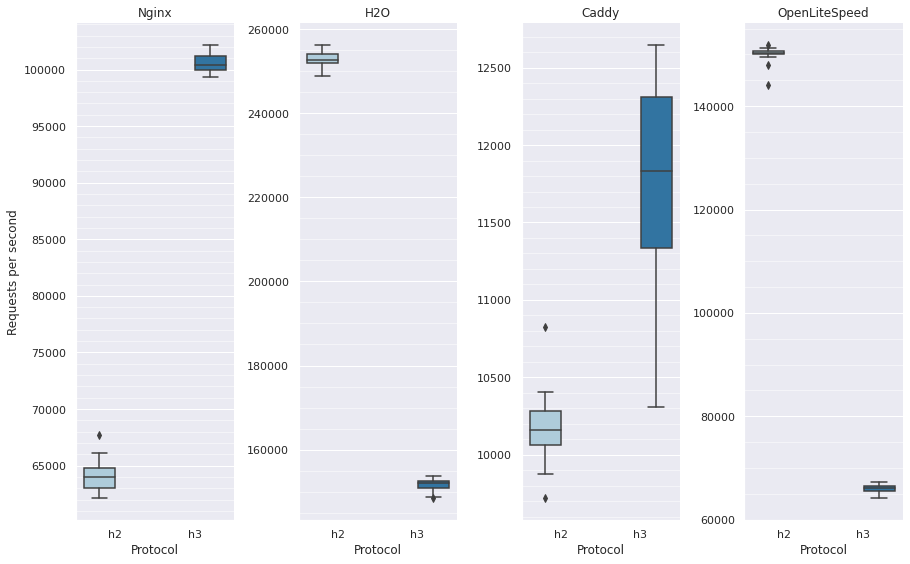

In [5]:
df_rps= pd.DataFrame(data_rps)
sns.set(rc={'figure.figsize':(20,10)})

g = sns.catplot(x="protocol", y="rps",hue="protocol", col="server",data=df_rps, kind="box",height=8, aspect=.4, palette="Paired", sharey=False);
g.set_xlabels('Protocol')
g.set_ylabels('Requests per second')
for p in g.axes.flatten():
    p.set_title(get_title_from_subplot(str(p.title)))
    p.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    p.grid(visible=True, which='minor', color='w', linewidth=0.5)

# RPS with single connection (vary multiplexing level)

In [6]:
data_rps = {
    "server": [],
    "rps": [],
    "protocol": [],
    "stream_n": [],
}

for server in servers:
    for protocol in ("h2", "h3"):
        print(f"rps test {protocol} - {server['name']}")
        for stream_number in range(1, 101):
            res = !h2load -D5s -t 1 -c 1 -m {stream_number} --npn-list={protocol} https://{server['ip']}/index.html
            data_rps['server'].append(server['name'])
            data_rps['rps'].append(get_rps(res))
            data_rps['protocol'].append("HTTP/2" if protocol == "h2" else "HTTP/3")
            data_rps['stream_n'].append(stream_number)
            print(f"streams_n={stream_number} {get_rps(res)} req/s (succ: {get_success_pct(res):.3f})")
        print(f"Finished geting measurements for {server} {protocol}")

rps test h2 - Nginx
streams_n=1 4334.2 req/s (succ: 1.000)
streams_n=2 8735.2 req/s (succ: 1.000)
streams_n=3 13318.8 req/s (succ: 1.000)
streams_n=4 16871.6 req/s (succ: 1.000)
streams_n=5 19280.0 req/s (succ: 1.000)
streams_n=6 20000.0 req/s (succ: 1.000)
streams_n=7 20000.0 req/s (succ: 1.000)
streams_n=8 20000.0 req/s (succ: 1.000)
streams_n=9 20000.0 req/s (succ: 1.000)
streams_n=10 20000.0 req/s (succ: 1.000)
streams_n=11 20000.0 req/s (succ: 1.000)
streams_n=12 20000.0 req/s (succ: 1.000)
streams_n=13 20000.0 req/s (succ: 1.000)
streams_n=14 20000.0 req/s (succ: 1.000)
streams_n=15 20000.0 req/s (succ: 1.000)
streams_n=16 16285.0 req/s (succ: 1.000)
streams_n=17 18331.8 req/s (succ: 1.000)
streams_n=18 20000.0 req/s (succ: 1.000)
streams_n=19 20000.0 req/s (succ: 1.000)
streams_n=20 20000.0 req/s (succ: 1.000)
streams_n=21 20000.0 req/s (succ: 1.000)
streams_n=22 20000.0 req/s (succ: 1.000)
streams_n=23 20000.0 req/s (succ: 1.000)
streams_n=24 20000.0 req/s (succ: 1.000)
streams

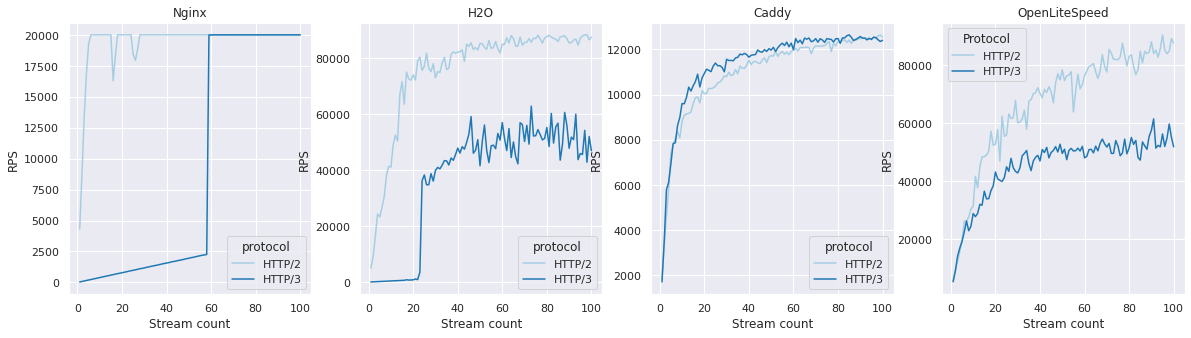

In [21]:
df = pd.DataFrame(data_rps)
df = df.replace({"h2": "HTTP/2", "h3": "HTTP/3"})
f, axs = plt.subplots(1,len(servers),
                      figsize=(20,5),
                      sharey=False)
for i, server in enumerate(servers):
    df_s = df[df['server'] == server['name']]
    sns.set_style("darkgrid")
    sns.lineplot(x="stream_n", y="rps", hue="protocol", data=df_s, palette="Paired", ax=axs[i]).set(title=server['name'], xlabel="Stream count", ylabel="RPS")
    plt.legend(title='Protocol', labels=['HTTP/2', 'HTTP/3'])
df.to_csv("rps_variable_stream.csv")
plt.show()

# RPS with varying connection number

In [43]:
data_rps = {
    "server": [],
    "rps": [],
    "protocol": [],
    "client_n": [],
}

for server in servers:
    for protocol in ("h2", "h3"):
        print(f"rps test {protocol} - {server['name']}")
        for client_number in range(1, 101, 1):
            res = !h2load -D5s -t 1 -c 1 -m 100 --npn-list={protocol} https://{server['ip']}/index.html
            data_rps['server'].append(server['name'])
            data_rps['rps'].append(get_rps(res))
            data_rps['protocol'].append(protocol)
            data_rps['client_n'].append(client_number)
            print(f"{get_rps(res)} req/s (succ: {get_success_pct(res):.3f})")
        print(f"Finished geting measurements for {server} {protocol}")

rps test h2 - Nginx
40540.45 req/s (succ: 1.000)
51223.39 req/s (succ: 1.000)
48456.0 req/s (succ: 1.000)
51354.11 req/s (succ: 1.000)
51728.37 req/s (succ: 1.000)
51566.62 req/s (succ: 1.000)
50915.33 req/s (succ: 1.000)
51088.44 req/s (succ: 1.000)
50960.45 req/s (succ: 1.000)
51956.42 req/s (succ: 1.000)
50859.6 req/s (succ: 1.000)
50179.64 req/s (succ: 1.000)
50584.27 req/s (succ: 1.000)
50387.12 req/s (succ: 1.000)
51612.66 req/s (succ: 1.000)
51708.18 req/s (succ: 1.000)
48519.78 req/s (succ: 1.000)
48436.59 req/s (succ: 1.000)
54152.38 req/s (succ: 1.000)
52397.39 req/s (succ: 1.000)
Finished geting measurements for {'name': 'Nginx', 'ip': 'nginx.antoniszczepanik.com'} h2
rps test h3 - Nginx
84292.3 req/s (succ: 1.000)
76680.12 req/s (succ: 1.000)
75723.61 req/s (succ: 1.000)
79762.18 req/s (succ: 1.000)
78503.6 req/s (succ: 1.000)
80329.54 req/s (succ: 1.000)
75387.55 req/s (succ: 1.000)
78243.1 req/s (succ: 1.000)
74065.95 req/s (succ: 1.000)
74174.57 req/s (succ: 1.000)
74483

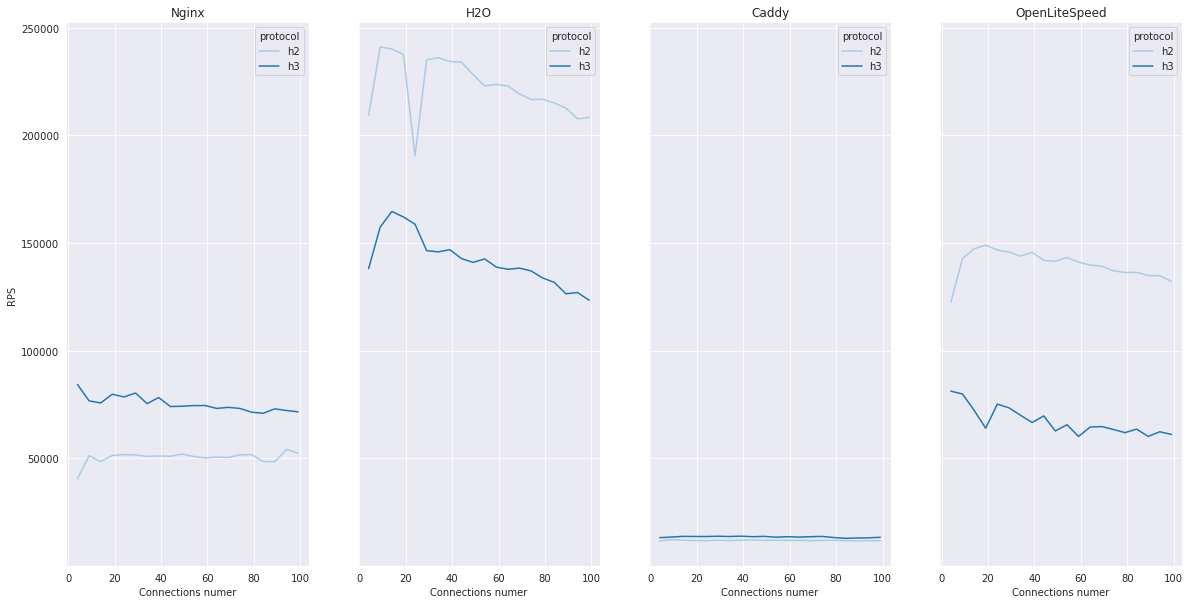

In [44]:
df = pd.DataFrame(data_rps)
f, axs = plt.subplots(1,len(servers),
                      figsize=(20,10),
                      sharey=True)
for i, server in enumerate(servers):
    df_s = df[df['server'] == server['name']]
    sns.set_style("darkgrid")
    sns.lineplot(x="client_n", y="rps", hue="protocol", data=df_s, palette="Paired", ax=axs[i]).set(title=server['name'], xlabel="Connections numer", ylabel="RPS")

plt.show()